In [1]:
import time
import datetime
from typing import Any

import numpy as np

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import metpy.calc as mpcalc
from metpy.units import units

import nzthermo as nzt
Pa = units.pascal
K = units.kelvin


In [2]:
# load data
isobaric = xr.open_dataset(
    "data/hrrr.t00z.wrfprsf00.grib2",
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "isobaricInhPa"}},
)

surface = xr.open_dataset(
    "data/hrrr.t00z.wrfsfcf00.grib2",
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface", "stepType": "instant"}},
)

T = isobaric["t"].to_numpy()  # (K) (Z, Y, X)
Z, Y, X = T.shape
N = Y * X
T = T.reshape(Z, N).transpose()  # (N, Z)

P = isobaric["isobaricInhPa"].to_numpy().astype(np.float32) * 100.0  # (Pa)
Q = isobaric["q"].to_numpy()  # (kg/kg) (Z, Y, X)
Q = Q.reshape(Z, N).transpose()  # (N, Z)
Td = nzt.dewpoint_from_specific_humidity(P, Q)

latitude = isobaric["latitude"].to_numpy()
longitude = isobaric["longitude"].to_numpy()
longitude = (longitude + 180) % 360 - 180
timestamp = datetime.datetime.fromisoformat(isobaric["time"].to_numpy().astype(str).item())

extent = [longitude.min(), longitude.max(), latitude.min(), latitude.max()]

Ignoring index file 'data/hrrr.t00z.wrfprsf00.grib2.9093e.idx' incompatible with GRIB file
Ignoring index file 'data/hrrr.t00z.wrfsfcf00.grib2.9093e.idx' older than GRIB file


In [3]:
def get_data(**sel: Any):
    ds = isobaric.sel(**sel)
    T = ds["t"].to_numpy()  # (K) (Z, Y, X)
    Z, Y, X = T.shape
    N = Y * X
    T = T.reshape(Z, N).transpose()  # (N, Z)
    P = ds["isobaricInhPa"].to_numpy().astype(np.float32) * 100.0  # (Pa)
    Q = ds["q"].to_numpy()  # (kg/kg) (Z, Y, X)
    Q = Q.reshape(Z, N).transpose()  # (N, Z)
    Td = nzt.dewpoint_from_specific_humidity(P, Q)
    lat = ds["latitude"].to_numpy()
    lon = (ds["longitude"].to_numpy() + 180) % 360 - 180
    timestamp = datetime.datetime.fromisoformat(ds["time"].to_numpy().astype(str).item())
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]

    return (P, T, Td), (Z, Y, X), (lat, lon, timestamp, extent)

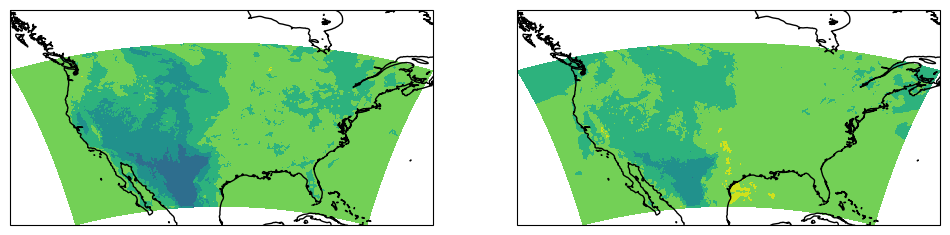

In [4]:
LCL_P, LCL_T = nzt.lcl(P[0], T[:, 0], Td[:, 0])
LCL_P = LCL_P.reshape(Y, X)
LCL_T = LCL_T.reshape(Y, X)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})


ax1.coastlines()
ax1.set_extent(extent)
ax1.contourf(longitude, latitude, LCL_P, transform=ccrs.PlateCarree())


ax2.coastlines()
ax2.set_extent(extent)
ax2.contourf(longitude, latitude, LCL_T, transform=ccrs.PlateCarree())

In [5]:
Td = nzt.dewpoint_from_specific_humidity(P[np.newaxis], Q)

In [6]:
prof = nzt.parcel_profile(P, T[:, 0], Td[:, 0])

In [7]:
el_p, el_t = nzt.el(P, T, Td, prof).reshape(Y, X)

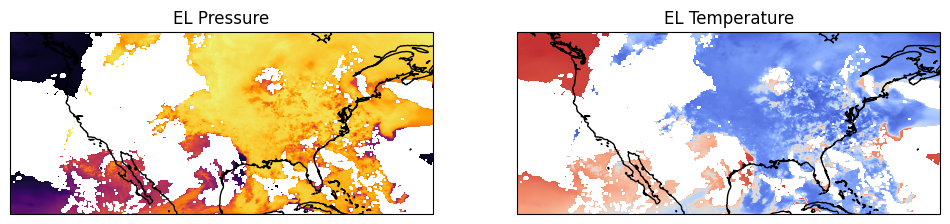

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

ax1.imshow(el_p, extent=extent, origin="upper", cmap="inferno_r")
ax1.set_title("EL Pressure")
ax1.coastlines()

ax2.imshow(el_t, extent=extent, origin="upper", cmap="coolwarm")
ax2.set_title("EL Temperature")
ax2.coastlines();


In [9]:
lfc_p, lfc_t = nzt.lfc(P, T, Td, prof).reshape(Y, X)

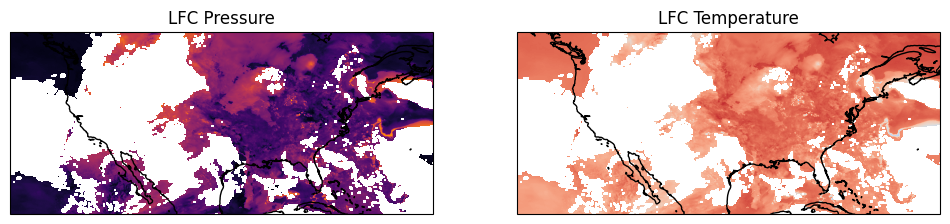

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})


ax1.imshow(lfc_p, extent=extent, origin="upper", cmap="inferno_r")
ax1.set_title("LFC Pressure")
ax1.coastlines()

ax2.imshow(lfc_t, extent=extent, origin="upper", cmap="coolwarm")
ax2.set_title("LFC Temperature")
ax2.coastlines();

# CAPE (Convective Available Potential Energy) & CIN (Convective Inhibition) Calculation

In [11]:
(P, T, Td), (Z, Y, X), (latitude, longitude, timestamp, extent) = get_data()
prof = nzt.parcel_profile(P, T[:, 0], Td[:, 0]) # (N, Z)

CAPE, CIN = nzt.cape_cin(P, T, Td, prof)

CAPE = CAPE.reshape(Y, X)
CIN = CIN.reshape(Y, X)

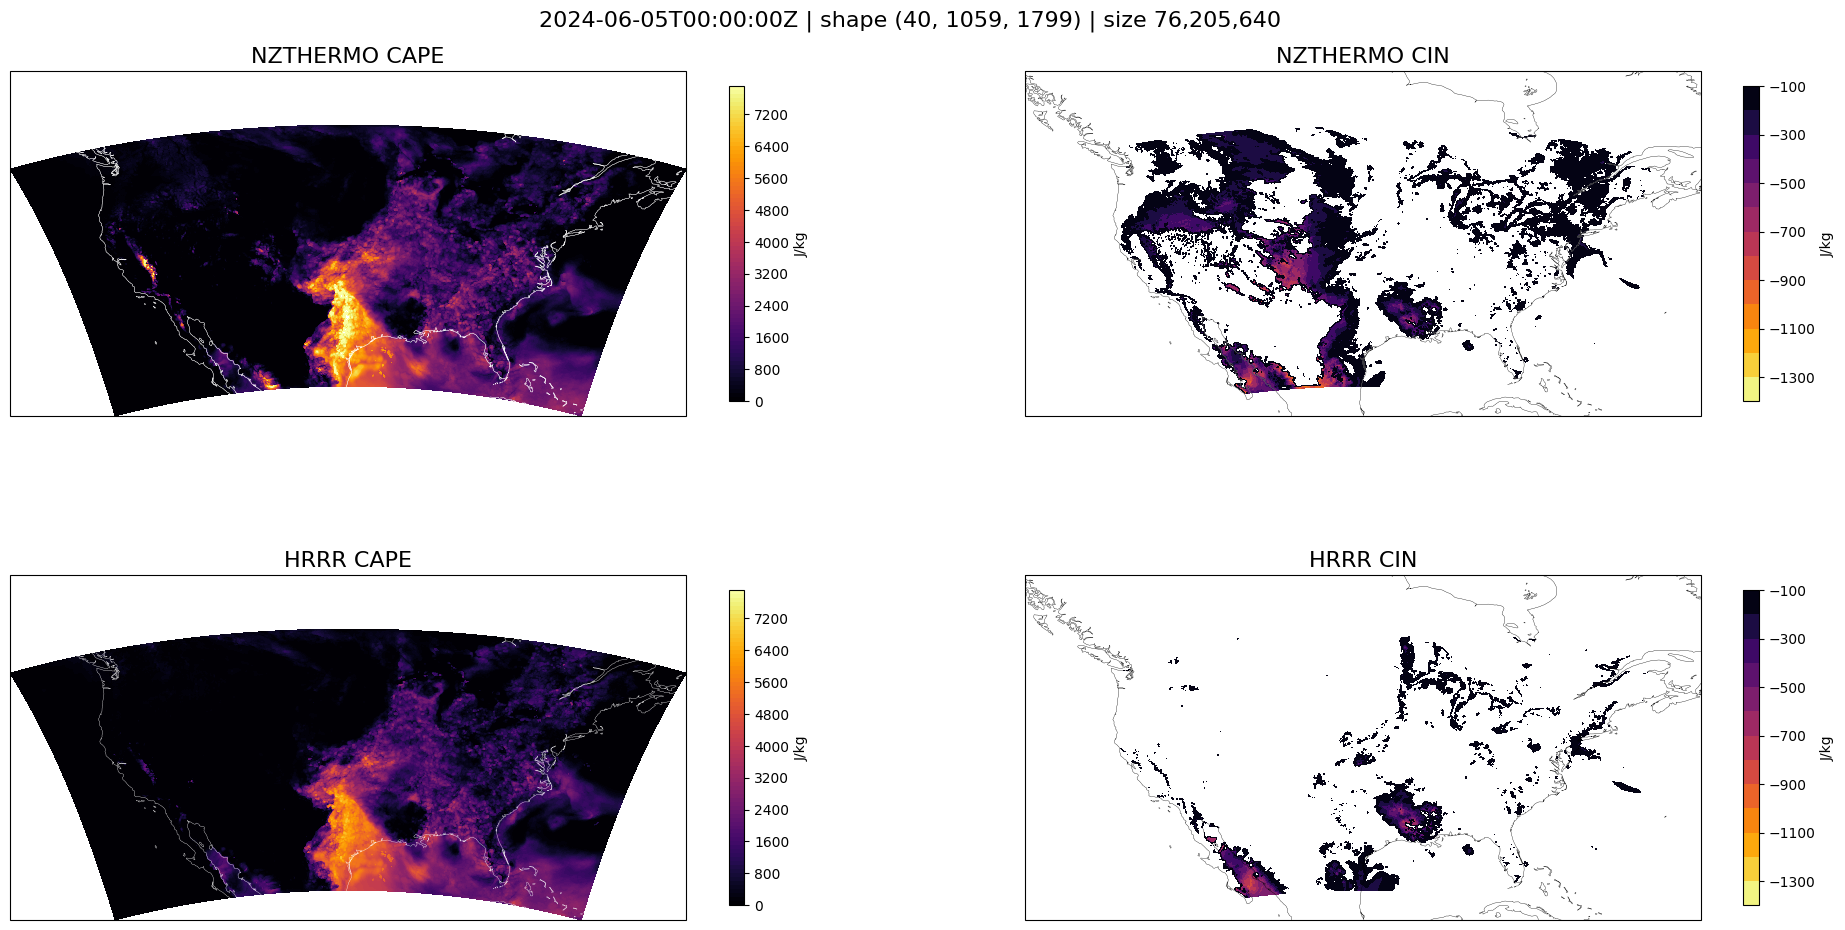

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12), subplot_kw={"projection": ccrs.PlateCarree()})
fig.suptitle(f"{timestamp:%Y-%m-%dT%H:%M:%SZ} | shape {Z, Y, X} | size {Z*Y*X:,}", fontsize=16, y=0.9)
# I suspect that the difference between our cape calculations and the MRMS cape calculations is due
# to the fact we are not actually starting at the surface or accounting for surface elevation.
# leading to inflated cape values in areas of higher elevation.
cape = CAPE
cin = CIN
# cape = np.where(CAPE < 8000, CAPE, 8000)
# cape = np.where(CAPE > 0, cape, 0)
# cin = np.where(CIN > -1400, CIN, -1400)

for ax, data, title, cmap in zip(
    axes[0], [cape, cin], ["NZTHERMO CAPE", "NZTHERMO CIN"], ["inferno", "inferno_r"]
):
    ax.coastlines(color="white", linewidth=0.25)
    ax.set_title(title, fontsize=16)
    ax.set_extent(extent)
    kwargs = {}
    if title.endswith("CIN"):
        kwargs["levels"] = np.arange(-1400, 0, 100)
        ax.coastlines(color="black", linewidth=0.25)
    else:
        kwargs["levels"] = np.arange(0, 8000, 100)
        ax.coastlines(color="white", linewidth=0.25)

    cf = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap, **kwargs)
    plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)

HRRR_CAPE = surface["cape"].to_numpy()
HRRR_CIN = surface["cin"].to_numpy()
for ax, data, title, cmap in zip(
    axes[1], [HRRR_CAPE, HRRR_CIN], ["HRRR CAPE", "HRRR CIN"], ["inferno", "inferno_r"]
):
    ax.set_title(title, fontsize=16)
    ax.set_extent(extent)
    if title.endswith("CIN"):
        kwargs["levels"] = np.arange(-1400, 0, 100)
        ax.coastlines(color="black", linewidth=0.25)
    else:
        kwargs["levels"] = np.arange(0, 8000, 100)
        ax.coastlines(color="white", linewidth=0.25)

    cf = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap, **kwargs)
    plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)



# Most Unstable CAPE & CIN

In [13]:
(P, T, Td), (Z, Y, X), (latitude, longitude, timestamp, extent) = get_data()


MU_CAPE, MU_CIN = nzt.most_unstable_cape_cin(P, T, Td, depth=1000)

MU_CAPE = MU_CAPE.reshape(Y, X)
MU_CIN = MU_CIN.reshape(Y, X)

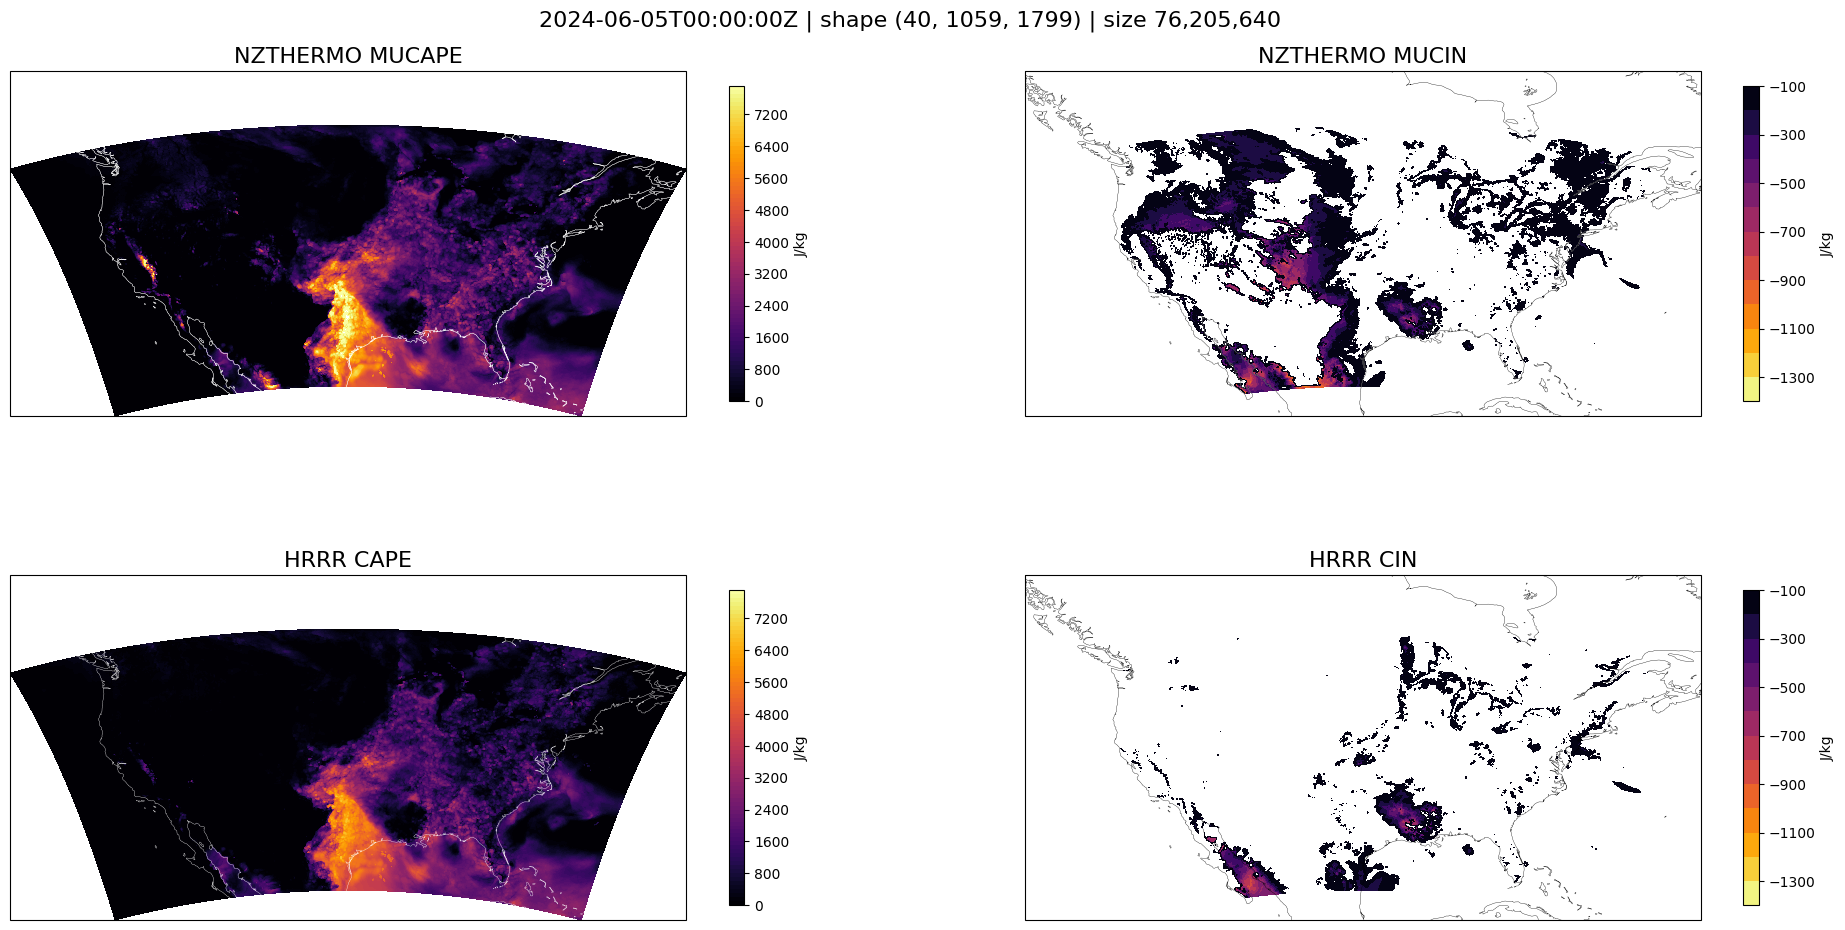

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12), subplot_kw={"projection": ccrs.PlateCarree()})
fig.suptitle(f"{timestamp:%Y-%m-%dT%H:%M:%SZ} | shape {Z, Y, X} | size {Z*Y*X:,}", fontsize=16, y=0.9)
# I suspect that the difference between our cape calculations and the MRMS cape calculations is due
# to the fact we are not actually starting at the surface or accounting for surface elevation.
# leading to inflated cape values in areas of higher elevation.
cape = MU_CAPE
cin = CIN
# cape = np.where(CAPE < 8000, CAPE, 8000)
# cape = np.where(CAPE > 0, cape, 0)
# cin = np.where(CIN > -1400, CIN, -1400)

for ax, data, title, cmap in zip(
    axes[0], [cape, cin], ["NZTHERMO MUCAPE", "NZTHERMO MUCIN"], ["inferno", "inferno_r"]
):
    ax.coastlines(color="white", linewidth=0.25)
    ax.set_title(title, fontsize=16)
    ax.set_extent(extent)
    kwargs = {}
    if title.endswith("CIN"):
        kwargs["levels"] = np.arange(-1400, 0, 100)
        ax.coastlines(color="black", linewidth=0.25)
    else:
        kwargs["levels"] = np.arange(0, 8000, 100)
        ax.coastlines(color="white", linewidth=0.25)

    cf = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap, **kwargs)
    plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)

HRRR_CAPE = surface["cape"].to_numpy()
HRRR_CIN = surface["cin"].to_numpy()
for ax, data, title, cmap in zip(
    axes[1], [HRRR_CAPE, HRRR_CIN], ["HRRR CAPE", "HRRR CIN"], ["inferno", "inferno_r"]
):
    ax.set_title(title, fontsize=16)
    ax.set_extent(extent)
    if title.endswith("CIN"):
        kwargs["levels"] = np.arange(-1400, 0, 100)
        ax.coastlines(color="black", linewidth=0.25)
    else:
        kwargs["levels"] = np.arange(0, 8000, 100)
        ax.coastlines(color="white", linewidth=0.25)

    cf = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap, **kwargs)
    plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)


# MIXED LAYER CAPE CIN

In [15]:
(P, T, Td), (Z, Y, X), (latitude, longitude, timestamp, extent) = get_data()

In [16]:
ML_CAPE, ML_CIN = nzt.mixed_layer_cape_cin(P, T, Td)

ML_CAPE = ML_CAPE.reshape(Y, X)
ML_CIN = ML_CIN.reshape(Y, X)

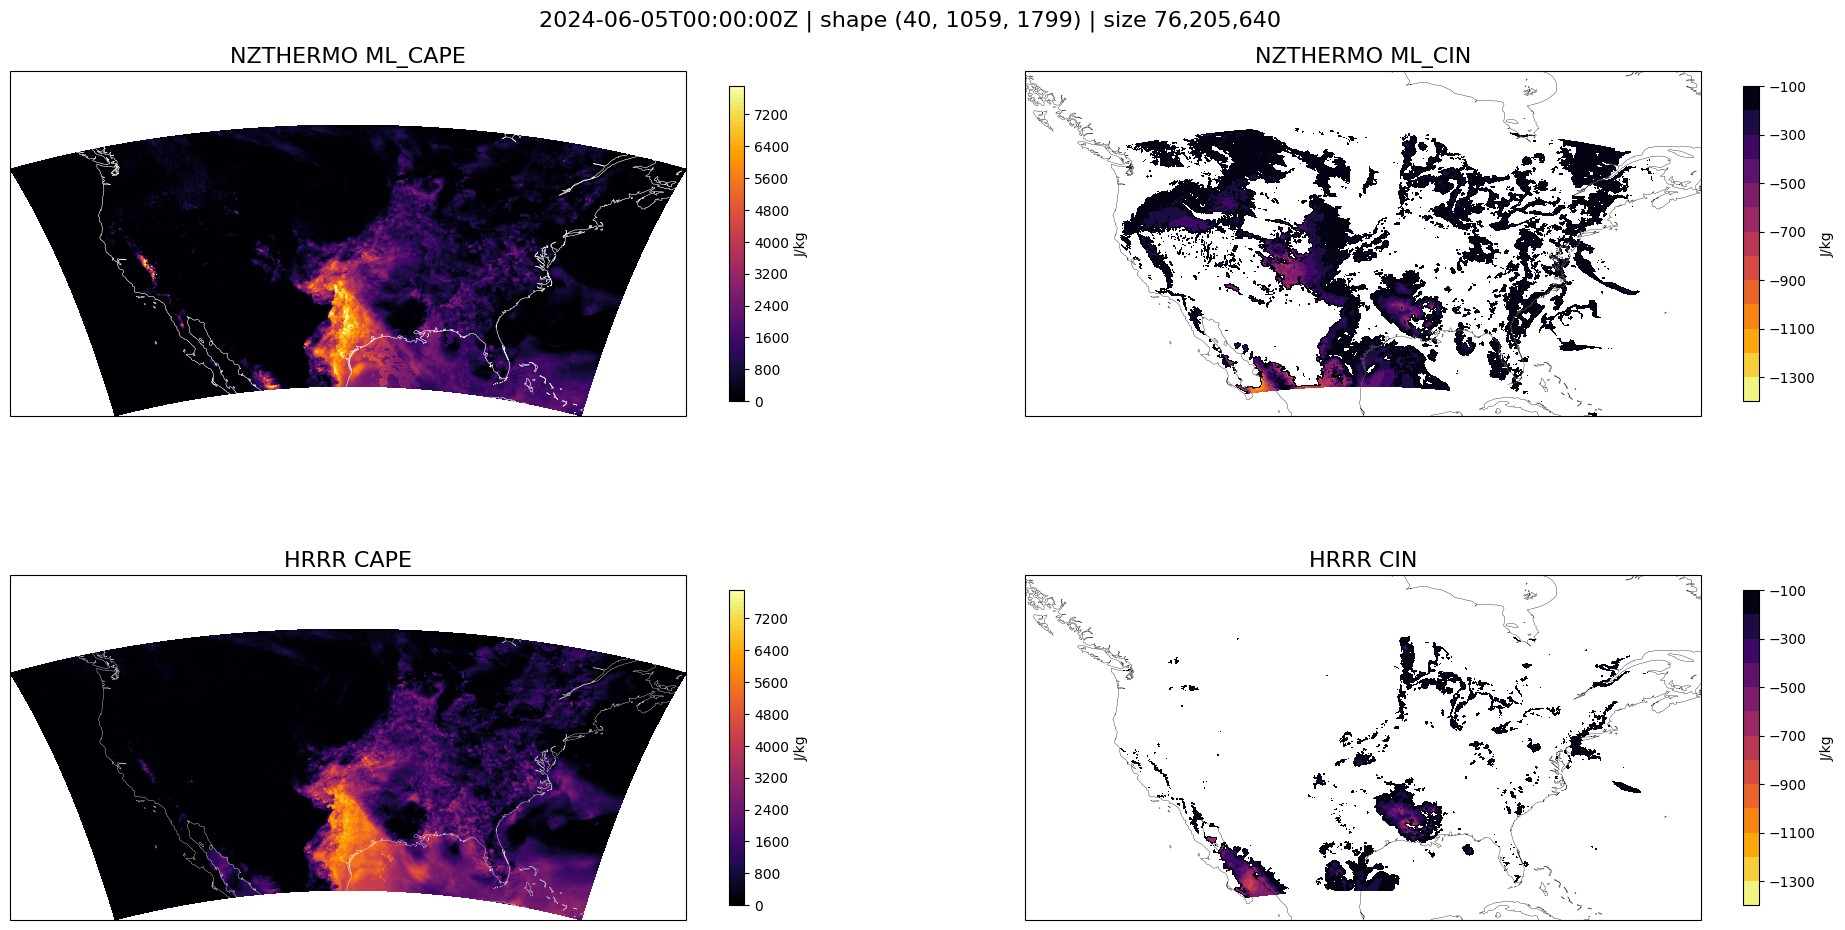

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12), subplot_kw={"projection": ccrs.PlateCarree()})
fig.suptitle(f"{timestamp:%Y-%m-%dT%H:%M:%SZ} | shape {Z, Y, X} | size {Z*Y*X:,}", fontsize=16, y=0.9)
# I suspect that the difference between our cape calculations and the MRMS cape calculations is due
# to the fact we are not actually starting at the surface or accounting for surface elevation.
# leading to inflated cape values in areas of higher elevation.
cape = ML_CAPE
cin = ML_CIN
# cape = np.where(CAPE < 8000, CAPE, 8000)
# cape = np.where(CAPE > 0, cape, 0)
# cin = np.where(CIN > -1400, CIN, -1400)

for ax, data, title, cmap in zip(
    axes[0], [cape, cin], ["NZTHERMO ML_CAPE", "NZTHERMO ML_CIN"], ["inferno", "inferno_r"]
):
    ax.coastlines(color="white", linewidth=0.25)
    ax.set_title(title, fontsize=16)
    ax.set_extent(extent)
    kwargs = {}
    if title.endswith("CIN"):
        kwargs["levels"] = np.arange(-1400, 0, 100)
        ax.coastlines(color="black", linewidth=0.25)
    else:
        kwargs["levels"] = np.arange(0, 8000, 100)
        ax.coastlines(color="white", linewidth=0.25)

    cf = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap, **kwargs)
    plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)

HRRR_CAPE = surface["cape"].to_numpy()
HRRR_CIN = surface["cin"].to_numpy()
for ax, data, title, cmap in zip(
    axes[1], [HRRR_CAPE, HRRR_CIN], ["HRRR CAPE", "HRRR CIN"], ["inferno", "inferno_r"]
):
    ax.set_title(title, fontsize=16)
    ax.set_extent(extent)
    if title.endswith("CIN"):
        kwargs["levels"] = np.arange(-1400, 0, 100)
        ax.coastlines(color="black", linewidth=0.25)
    else:
        kwargs["levels"] = np.arange(0, 8000, 100)
        ax.coastlines(color="white", linewidth=0.25)

    cf = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap, **kwargs)
    plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)

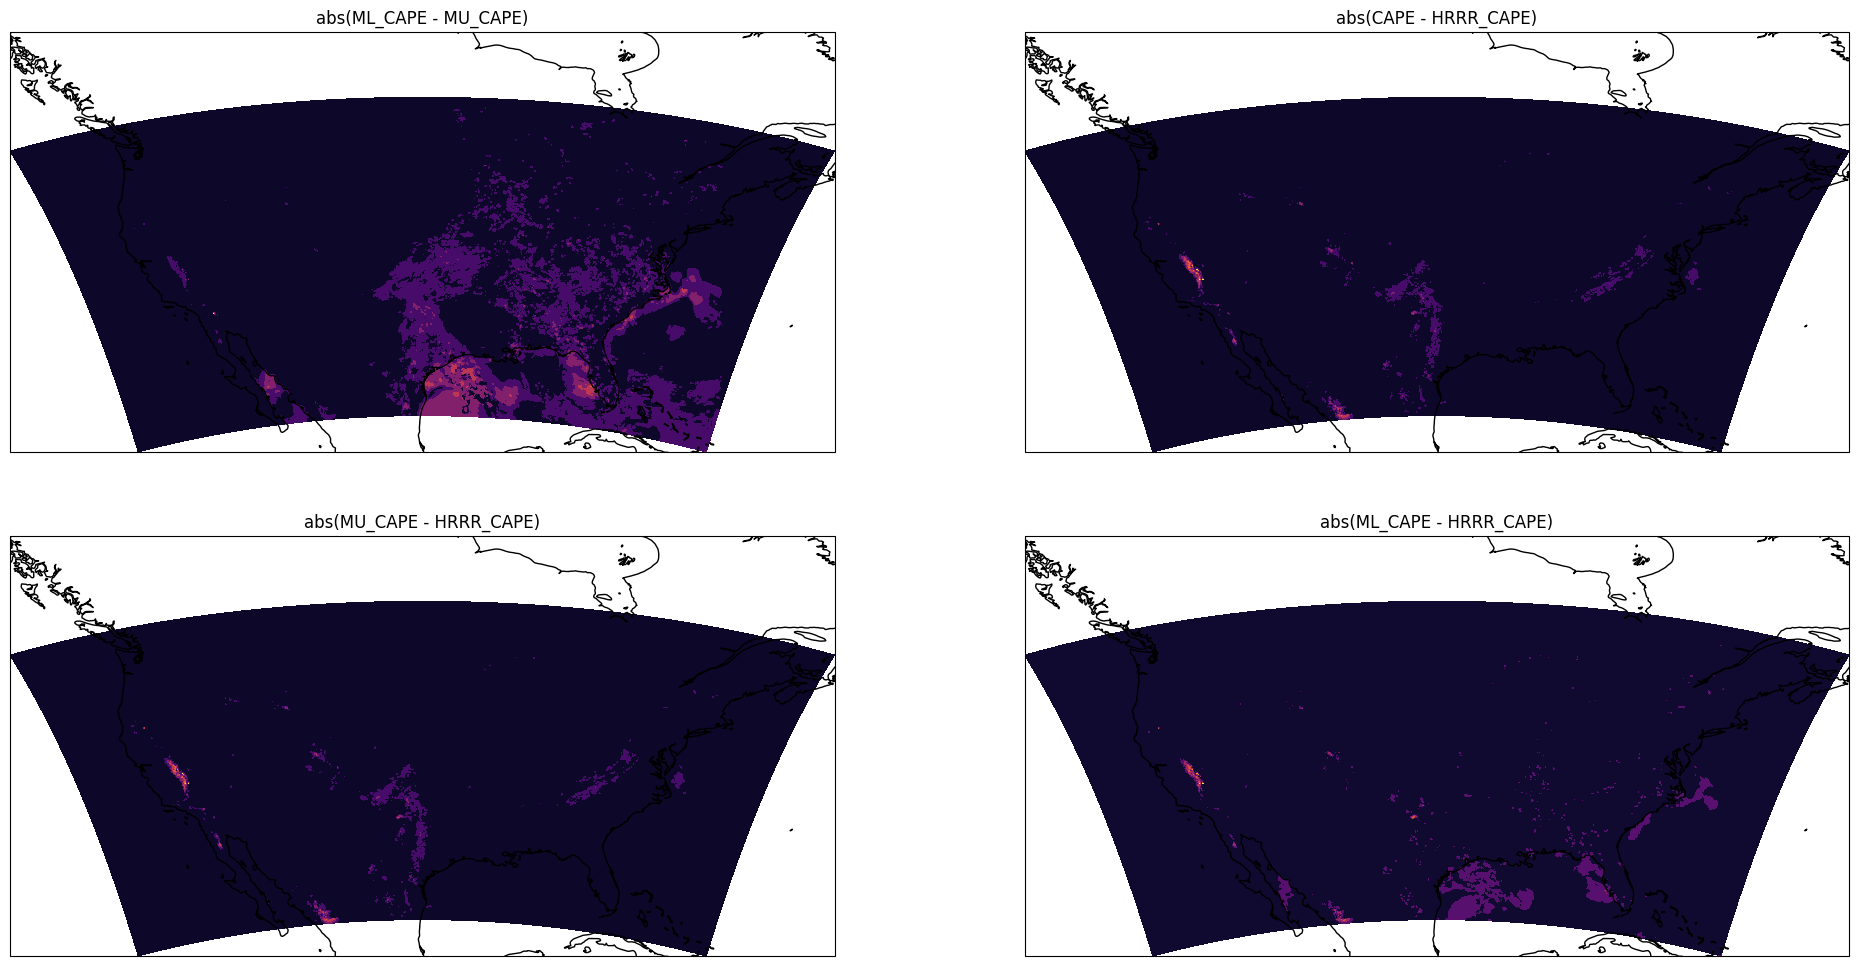

In [52]:
(P, T, Td), (Z, Y, X), (latitude, longitude, timestamp, extent) = get_data()

fig, axes = plt.subplots(2, 2, figsize=(24, 12), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()
ax = axes[0]
ax.coastlines()
ax.set_extent(extent)
ax.contourf(longitude, latitude, np.abs(ML_CAPE - MU_CAPE), transform=ccrs.PlateCarree(), cmap="inferno")
ax.set_title("abs(ML_CAPE - MU_CAPE)")

ax = axes[1]
ax.coastlines()
ax.set_extent(extent)
ax.contourf(longitude, latitude, np.abs(CAPE - HRRR_CAPE), transform=ccrs.PlateCarree(), cmap="inferno")
ax.set_title("abs(CAPE - HRRR_CAPE)")

ax = axes[2]
ax.coastlines()
ax.set_extent(extent)
ax.contourf(longitude, latitude, np.abs(MU_CAPE - HRRR_CAPE), transform=ccrs.PlateCarree(), cmap="inferno")
ax.set_title("abs(MU_CAPE - HRRR_CAPE)")


ax = axes[3]
ax.coastlines()
ax.set_extent(extent)
ax.contourf(longitude, latitude, np.abs(ML_CAPE - HRRR_CAPE), transform=ccrs.PlateCarree(), cmap="inferno")
ax.set_title("abs(ML_CAPE - HRRR_CAPE)");


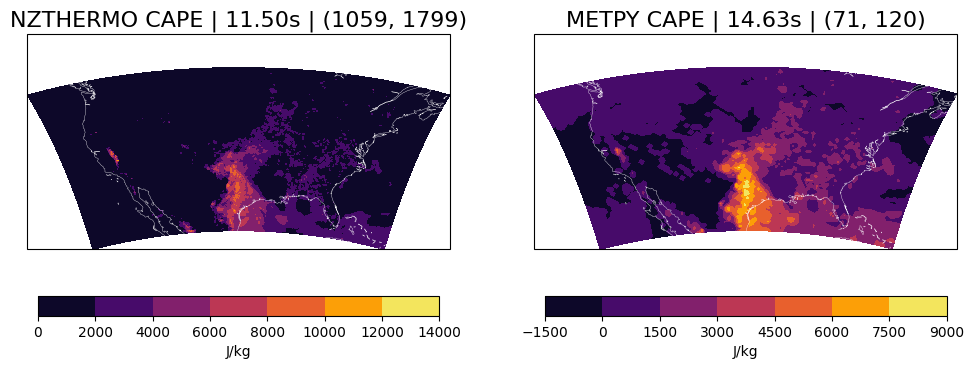

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12), subplot_kw={"projection": ccrs.PlateCarree()})


# ............................................................................................... #
# nzthermo cape
# ............................................................................................... #
ax = axes[0]
(P, T, Td), (Z, Y, X), (latitude, longitude, timestamp, extent) = get_data()
prof = nzt.parcel_profile(P, T[:, 0], Td[:, 0])


start = time.time()
CAPE, _ = nzt.cape_cin(P, T, Td, prof)
elapsed = time.time() - start

CAPE = CAPE.reshape(Y, X)

ax.coastlines(color="white", linewidth=0.25)
ax.set_title(f"NZTHERMO CAPE | {elapsed:.2f}s | {Y, X}", fontsize=16)
ax.set_extent(extent)
cf = ax.contourf(longitude, latitude, CAPE, transform=ccrs.PlateCarree(), cmap="inferno")

plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, label="J/kg", shrink=0.95)
# ............................................................................................... #
# metpy cape
# ............................................................................................... #
ax = axes[1]
(P, T, Td), (Z, Y, X), (latitude, longitude, timestamp, extent) = get_data(
    # we are plotting at a much lower resolution with metpy.
    x = slice(None, None, 15), 
    y = slice(None, None, 15),
)


prof = nzt.parcel_profile(P, T[:, 0], Td[:, 0]) * K


P*= Pa
T*= K
Td *= K

start = time.time()
METPY_CAPE = np.array([mpcalc.cape_cin(P, T[i, :], Td[i, :], prof[i])[0].m for i in range(Y * X)])
elapsed = time.time() - start

METPY_CAPE = METPY_CAPE.reshape(Y, X)

ax.coastlines(color="white", linewidth=0.25)
ax.set_title(f"METPY CAPE | {elapsed:.2f}s | {Y, X}", fontsize=16)
ax.set_extent(extent)
cf = ax.contourf(longitude, latitude, METPY_CAPE, transform=ccrs.PlateCarree(), cmap="inferno")

plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, label="J/kg", shrink=0.95);

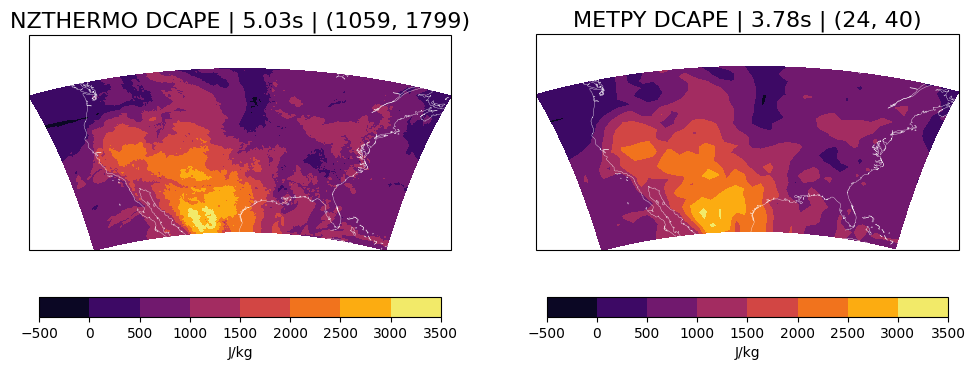

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12), subplot_kw={"projection": ccrs.PlateCarree()})


# ............................................................................................... #
# nzthermo dcape
# ............................................................................................... #
ax = axes[0]
(P, T, Td), (Z, Y, X), (latitude, longitude, timestamp, extent) = get_data()

start = time.time()
DCAPE = nzt.downdraft_cape(P, T, Td)
elapsed = time.time() - start

DCAPE = DCAPE.reshape(Y, X)

ax.coastlines(color="white", linewidth=0.25)
ax.set_title(f"NZTHERMO DCAPE | {elapsed:.2f}s | {Y, X}", fontsize=16)
ax.set_extent(extent)
cf = ax.contourf(longitude, latitude, DCAPE, transform=ccrs.PlateCarree(), cmap="inferno")

plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, label="J/kg", shrink=0.95)
# ............................................................................................... #
# metpy dcape
# ............................................................................................... #
ax = axes[1]
(P, T, Td), (Z, Y, X), (latitude, longitude, timestamp, extent) = get_data(
    # we are plotting at a much lower resolution with metpy.
    x = slice(None, None, 45), 
    y = slice(None, None, 45),
)


P*= Pa
T*= K
Td *= K

start = time.time()
METPY_DCAPE = np.array([mpcalc.downdraft_cape(P, T[i, :], Td[i, :])[0].m for i in range(Y * X)])
elapsed = time.time() - start

METPY_DCAPE = METPY_DCAPE.reshape(Y, X)

ax.coastlines(color="white", linewidth=0.25)
ax.set_title(f"METPY DCAPE | {elapsed:.2f}s | {Y, X}", fontsize=16)
ax.set_extent(extent)
cf = ax.contourf(longitude, latitude, METPY_DCAPE, transform=ccrs.PlateCarree(), cmap="inferno")

plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, label="J/kg", shrink=0.95)